### Домашнє завдання: Пониження розмірностей для Аналізу Портретів Клієнтів

#### Контекст
В цьому ДЗ ми попрацюємо з методами пониження розмірності на наборі даних для задачі аналізу портретів клієнтів (Customer Personality Analysis). **В попередньому ДЗ ми працювали з цими даними використовуючи кластеризацію, зараз використаємо кластеризацію і візуалізауємо результати з різними методами.**

Customer Personality Analysis - це аналіз різних сегментів клієнтів компанії. Цей аналіз дозволяє бізнесу краще розуміти своїх клієнтів і полегшує процес адаптації продуктів під конкретні потреби, поведінку та інтереси різних типів клієнтів.

Аналіз портретів клієнтів допомагає бізнесу змінювати свій продукт на основі цільової аудиторії, розділеної на різні сегменти. Наприклад, замість того, щоб витрачати гроші на маркетинг нового продукту для всіх клієнтів у базі даних компанії, бізнес може проаналізувати, який сегмент клієнтів найімовірніше придбає продукт, і потім зосередити маркетингові зусилля лише на цьому сегменті.

#### Вхідні дані
Вам надано набір даних з такими атрибутами:

**Характеристики користувачів:**
- `ID`: Унікальний ідентифікатор клієнта
- `Year_Birth`: Рік народження клієнта
- `Education`: Рівень освіти клієнта
- `Marital_Status`: Сімейний стан клієнта
- `Income`: Річний дохід домогосподарства клієнта
- `Kidhome`: Кількість дітей у домогосподарстві клієнта
- `Teenhome`: Кількість підлітків у домогосподарстві клієнта
- `Dt_Customer`: Дата реєстрації клієнта у компанії
- `Recency`: Кількість днів з моменту останньої покупки клієнта
- `Complain`: 1, якщо клієнт скаржився за останні 2 роки, 0 - якщо ні

**Продукти:**
- `MntWines`: Сума, витрачена на вино за останні 2 роки
- `MntFruits`: Сума, витрачена на фрукти за останні 2 роки
- `MntMeatProducts`: Сума, витрачена на м'ясні продукти за останні 2 роки
- `MntFishProducts`: Сума, витрачена на рибні продукти за останні 2 роки
- `MntSweetProducts`: Сума, витрачена на солодощі за останні 2 роки
- `MntGoldProds`: Сума, витрачена на золото за останні 2 роки

**Акції:**
- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць


Для початку, запустіть код нижче. Всі ці кроки ми робили в попередньому ДЗ і для того, щоб результати кластеризації у нас були схожими, потрібно аби передобробка була однаковою.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
file_name = '/content/drive/MyDrive/ML/data/marketing_campaign.csv'

In [4]:
# 1. Завантаження даних
df = pd.read_csv(file_name, sep='\t')

# 2. Обробка пропущених значень
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

# 3. Обробка дати реєстрації
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)

# 4. Категоризація рівня освіти
df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)

# 5. Очищення сімейного стану
marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)

# 6. Форматування доходу і видалення викиду
df.Income = df.Income.astype(int)
df = df[df.Income != 666666]

# 7. Створення фінального набору даних
X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

In [5]:
X.head(5)

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Income_not_filled,days_lifetime,years_customer,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,marital_Else,marital_Single
0,1957,58138,0,0,58,635,88,546,172,88,...,False,663,57,0,0,1,0,0,0,0
1,1954,46344,1,1,38,11,1,6,2,1,...,False,113,60,0,0,1,0,0,0,0
2,1965,71613,0,0,26,426,49,127,111,21,...,False,312,49,0,0,1,0,0,0,0
3,1984,26646,1,0,26,11,4,20,10,3,...,False,139,30,0,0,1,0,0,0,0
4,1981,58293,1,0,94,173,43,118,46,27,...,False,161,33,0,0,0,0,1,0,0


### Завдання 1: Виконання кластеризації та пониження розмірності для візуалізації результатів

Ваше завдання — провести кластеризацію клієнтів та візуалізувати результати кластеризації, використовуючи метод головних компонент (PCA) для пониження розмірності даних.

#### Інструкції:

1. **Вибір ключових характеристик:**
   Давайте обмежимось тільки наступними хараткеристиками для кластеризації цього разу:
   - `Income`: Річний дохід домогосподарства клієнта
   - `Recency`: Кількість днів з моменту останньої покупки клієнта
   - `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
   - `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
   - `days_lifetime`: Кількість днів з моменту реєстрації клієнта у компанії
   - `years_customer`: Вік клієнта
   - `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць
   Відберіть в наборі даних `X` лише ці характеристики.

2. **Нормалізація даних:**
   Використайте метод `MinMaxScaler` для нормалізації значень обраних характеристик.

3. **Кластеризація:**
   Проведіть кластеризацію клієнтів, використовуючи метод `KMeans` з трьома кластерами.

4. **Пониження розмірності:**
   Використайте метод головних компонент (PCA) для пониження розмірності даних до трьох компонент.

5. **Візуалізація результатів:**
   Використовуючи plolty express побудуйте 3D-графік розподілу клієнтів у просторі трьох головних компонент, де кольором позначено кластери.

6. **Опишіть, що спостерігаєте:**
   Чи кластеризація чітко розділила дані?

Далі ми детальніше проінтерпретуємо результати візуалізації і пониження розмірностей.

In [6]:
selected_features = [
    "Income", "Recency", "NumStorePurchases", "NumDealsPurchases",
    "days_lifetime", "years_customer", "NumWebVisitsMonth"
]

X = X[selected_features].copy()

In [7]:
X.head(5)

,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
0,58138,58,4,3,663,57,7
1,46344,38,2,2,113,60,5
2,71613,26,10,1,312,49,4
3,26646,26,4,2,139,30,6
4,58293,94,6,5,161,33,5


In [8]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [10]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [11]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = clusters

In [12]:
fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color=pca_df['cluster'].astype(str),
    title='Кластеризація клієнтів у просторі головних компонент (PCA)'
)
fig.show()

In [13]:
def visualize_three_features(df, feature_1, feature_2, feature_3):
  plt.figure(figsize=(18, 5))

  plt.subplot(1, 3, 1)
  sns.scatterplot(data=df, x=feature_1, y=feature_2, hue="cluster", palette="Set1")
  plt.title(f"{feature_1} vs {feature_2}")

  plt.subplot(1, 3, 2)
  sns.scatterplot(data=df, x=feature_1, y=feature_3, hue="cluster", palette="Set1")
  plt.title(f"{feature_1} vs {feature_3}")

  plt.subplot(1, 3, 3)
  sns.scatterplot(data=df, x=feature_2, y=feature_3, hue="cluster", palette="Set1")
  plt.title(f"{feature_2} vs {feature_3}")

  plt.tight_layout()
  plt.show()

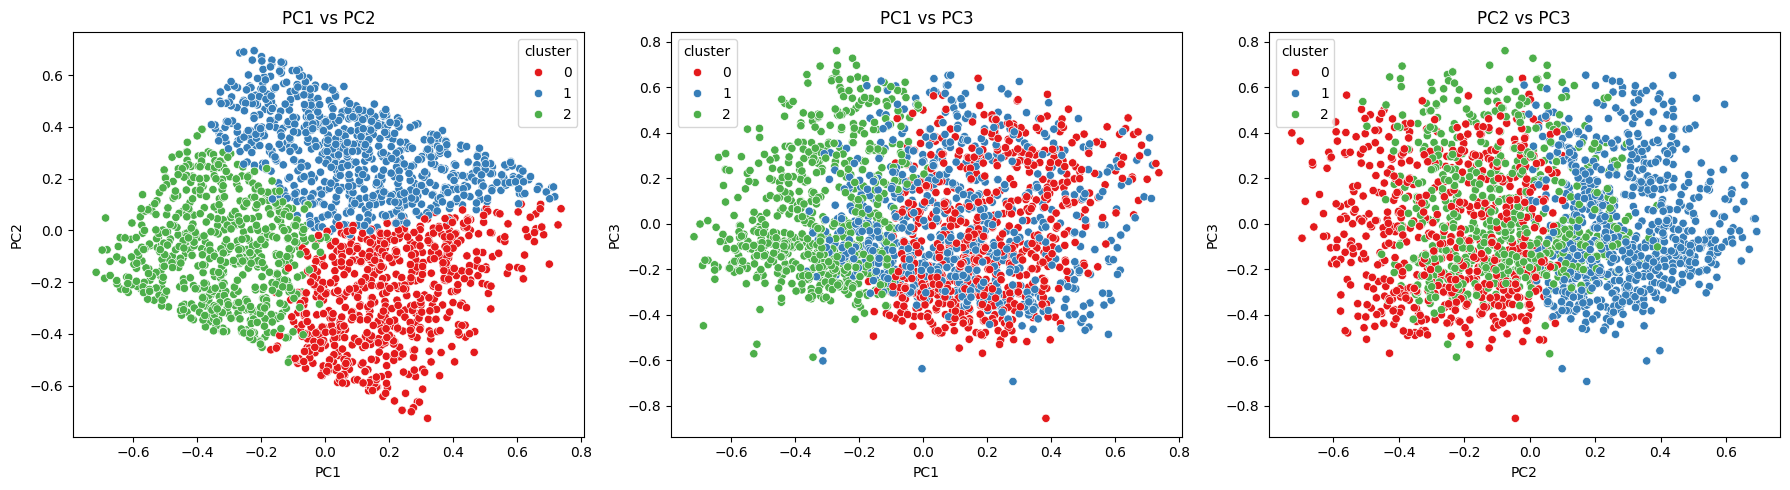

In [14]:
visualize_three_features(pca_df, 'PC1', 'PC2', 'PC3')

**Спостереження**:

В результаті візуалізації спостерігається розділення кластерів. У PC1 vs PC2 видно гарне розділення кластерів. З 3d візуалізації також можемо бачити доволі чітке робзбиття кластерів.

Найкраще розділення кластерів спостерігається у площині перших двох головних компонент (PC1 vs PC2), що свідчить про те, що основна варіативність даних з точки зору кластеризації відображена саме у цих компонентах. У площинах з третьою компонентою (PC3) межі між кластерами менш чіткі.

### Завдання 2: Аналіз результатів пониження розмірності

1. **Розрахунок частки поясненої дисперсії:**
   Визначте, яка частка загальної варіації даних пояснюється кожною з трьох головних компонент (PC1, PC2, PC3) за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA. Виведіть результат на екран.

2. **Розрахунок кумулятивної частки поясненої дисперсії:**
   Обчисліть кумулятивну частку поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [15]:
def pca_variance(pca, X_scaled, n_components=3):
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    print("Пояснена дисперсія по кожній головній компоненті")
    for i in range(n_components):
        print(f"Частка поясненої дисперії PC{i+1}: {explained_variance[i]:.4%}")
        print(f"Кумулятивна частка поясненої дисперсії PC{i+1}: {cumulative_explained_variance[i]:.4%}\n")

    return explained_variance[:n_components], cumulative_explained_variance[:n_components]

In [16]:
explained, cumulative = pca_variance(pca, X_scaled, n_components=3)

Пояснена дисперсія по кожній головній компоненті
Частка поясненої дисперії PC1: 30.2034%
Кумулятивна частка поясненої дисперсії PC1: 30.2034%

Частка поясненої дисперії PC2: 28.6653%
Кумулятивна частка поясненої дисперсії PC2: 58.8688%

Частка поясненої дисперії PC3: 25.1224%
Кумулятивна частка поясненої дисперсії PC3: 83.9912%



**Спостереження**:

Бачимо, що кожна трьох компонент пояснює значну частину варіації у даних.
Кумулятивно ці три компоненти пояснюють близько 84% загальної дисперсії даних, що є достатньо високим показником для збереження більшої частини інформації при зменшенні розмірності простору ознак.

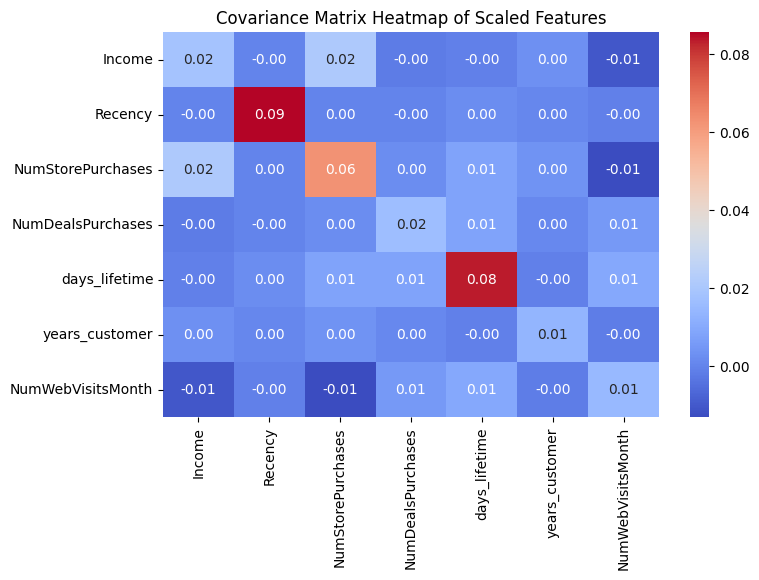

In [17]:
X_scaled_centered = X_scaled - X_scaled.mean()
cov_matrix_scaled = np.cov(X_scaled_centered.T)
cov_scaled_df = pd.DataFrame(cov_matrix_scaled, index=selected_features, columns=selected_features)

plt.figure(figsize=(8, 5))
sns.heatmap(cov_scaled_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Covariance Matrix Heatmap of Scaled Features')
plt.show()

In [18]:
eigenvalues_scaled, eigenvectors_scaled = np.linalg.eig(cov_matrix_scaled)
sorted_indices_scaled = np.argsort(eigenvalues_scaled)[::-1]
sorted_eigenvalues_scaled = eigenvalues_scaled[sorted_indices_scaled]
sorted_eigenvalues_scaled

array([0.08913581, 0.08459657, 0.07414076, 0.01900233, 0.01383999,
       0.00947421, 0.00492831])

In [19]:
explained_variance_ratio_scaled = sorted_eigenvalues_scaled / sorted_eigenvalues_scaled.sum()
cumulative_explained_variance_scaled = np.cumsum(explained_variance_ratio_scaled)
print(explained_variance_ratio_scaled)
print(cumulative_explained_variance_scaled)

[0.30203449 0.2866534  0.25122414 0.06438892 0.04689648 0.03210312
 0.01669944]
[0.30203449 0.5886879  0.83991203 0.90430095 0.95119744 0.98330056
 1.        ]


In [20]:
explained_variance_ratio_scaled

array([0.30203449, 0.2866534 , 0.25122414, 0.06438892, 0.04689648,
       0.03210312, 0.01669944])

### Завдання 3: Інтерпретація "Loadings"

Продовжуємо інтерпретацію результатів `PCA`і познайомимось з новим поняттям `loadings`, яке допоможе нам знайти звʼязок між головними компонентами і оригінальними ознаками в наборі даних.

Ми зараз побудували візуалізацію кластерів точок даних в просторі трьох головних компонент. Але хочеться знайти звʼязок між головними компонентами і оригінальними ознаками. Для розуміння, які початкові характеристики даних мають найбільший вплив на ці головні компоненти, ми можемо використати атрибут `components_` методу `PCA`.

#### Що таке `pca.components_`?

`pca.components_` — це масив, який містить коефіцієнти (або "ваги"), що показують внесок кожної вихідної ознаки у кожну з головних компонент. Ці коефіцієнти ще називаються **"loading"** або "навантаженнями" компонент.

- **Loadings** (`навантаження`) відображають важливість кожної змінної (ознаки) для відповідної головної компоненти. Вони показують, яким чином змінні поєднуються, щоб утворити нові, зменшені вимірювання.
- Якщо коефіцієнт має високе абсолютне значення (як позитивне, так і негативне), це вказує на те, що відповідна змінна сильно впливає на головну компоненту.

#### Саме завдання
Ваше завдання — обчислити "навантаження" для кожної з головних компонент і інтерпретувати результати.

1. **Обчислення loadings для компонент:**
   Використайте атрибут `components_` об'єкта PCA для створення DataFrame, який відображатиме внесок кожної вихідної ознаки в кожну головну компоненту.

2. **Інтерпретація результатів:**
   Виведіть значення "навантажень" і проаналізуйте, які ознаки найбільше впливають на кожну головну компоненту.

In [21]:
loading_matrix = eigenvectors_scaled[:, sorted_indices_scaled]
loading_df = pd.DataFrame(loading_matrix, index=selected_features, columns=[f'PC{i+1}' for i in range(len(loading_matrix[0]))])
display(loading_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Income,0.063557,0.047082,0.373826,0.288006,0.258675,-0.590928,-0.595770
Recency,0.475786,-0.878876,0.029910,-0.010742,-0.010376,-0.000315,-0.009315
NumStorePurchases,0.284282,0.187195,0.816668,-0.260712,-0.227220,0.311486,0.023911
NumDealsPurchases,0.103049,0.059324,-0.050687,-0.786352,0.192229,-0.531189,0.214076
days_lifetime,0.821912,0.431061,-0.305490,0.199592,0.033702,-0.021387,0.062396
years_customer,0.012658,-0.001022,0.080411,-0.045623,0.910422,0.402175,0.026055
NumWebVisitsMonth,0.049530,0.031377,-0.300089,-0.434394,-0.119982,0.330781,-0.770713


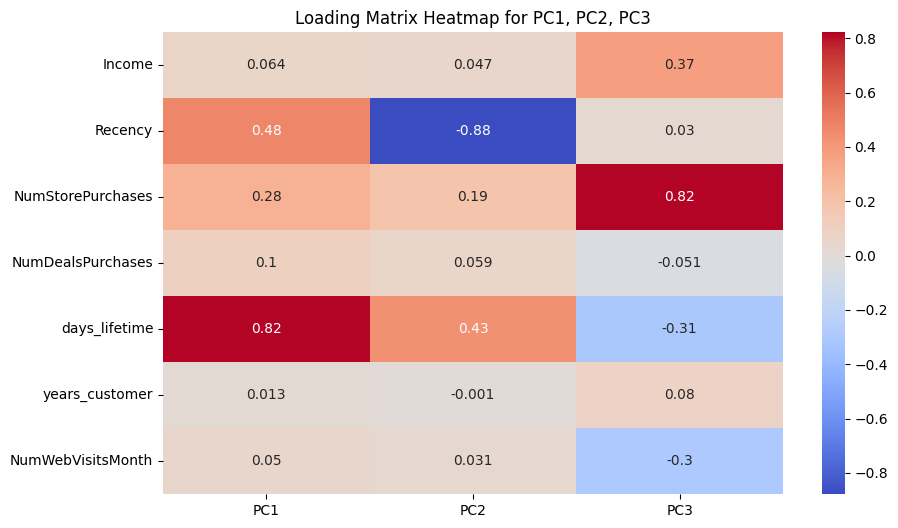

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(loading_df.iloc[:, :3], annot=True, cmap="coolwarm")
plt.title('Loading Matrix Heatmap for PC1, PC2, PC3')
plt.show()

Обчислимо `loadings` із застосування pca.components_:

In [23]:
loadings = pd.DataFrame(
    pca.components_,
    columns=selected_features,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

display(loadings)

,Income,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
PC1,0.063557,0.475786,0.284282,0.103049,0.821912,0.012658,0.049530
PC2,-0.047082,0.878876,-0.187195,-0.059324,-0.431061,0.001022,-0.031377
PC3,0.373826,0.029910,0.816668,-0.050687,-0.305490,0.080411,-0.300089


**Спостреження**:

> При аналізі впливу ознак на головні компоненти PCA було розглянуто два варіанти розрахунку: вручну через власні вектори коваріаційної матриці та  за допомогою pca.components_ із бібліотеки sklearn. В частині ознак може спостерігатися не співпадання по знаку.Для цілей аналізу та візуалізації враховується саме абсолютне значення коефіцієнтів, що дозволяє об'єктивно оцінити внесок кожної ознаки у формування компонент.

- PC1 найбільше залежить від days_lifetime, Recency та NumStorePurchases.  
- PC2 найбільше залежить від Recency та days_lifetime.
- PC3 найбільше залежить від NumStorePurchases, Income, days_lifetime та NumWebVisitsMonth.

Можемо сказати, що кожна компонента відображає свого роду реальні патерни поведінки клієнтів:

- PC1 - відображає часовий аспект поведінки клієнтів та інтенсивність їх взаємодії з компанією.
- PC2 - відображає переважно останні активності клієнтів.
- PC3 - більше відображає інтенсивність покупок.


###Завдання 4
Давайте проаналізуємо "навантаження" (**loadings**) для трьох головних компонент після вилучення ознаки `Income`. Це допоможе нам зрозуміти, як змінилася важливість інших ознак для кожної головної компоненти, коли одна з ключових характеристик (`Income`) була вилучена.

#### Кроки для проведення аналізу і ваше завдання:

1. Видаліть ознаку `Income` з нашого набору даних `X` і повторно виконайте PCA (метод головних компонент) для отримання нових "навантажень".

2. Обчисліть нові "навантаження" для трьох головних компонент на наборі даних без `Income`

3. Проаналізуйте, які ознаки мають найбільший вплив на кожну головну компоненту після вилучення `Income`.

4. Перегляньте, наскільки кожна з головних компонент пояснює дисперсію в даних без ознаки `Income`.

In [24]:
X_scaled_df = X_scaled.drop(columns=['Income'])

In [25]:
X_scaled_df.head(3)

,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
0,0.585859,0.307692,0.200000,0.948498,0.378641,0.35
1,0.383838,0.153846,0.133333,0.161660,0.407767,0.25
2,0.262626,0.769231,0.066667,0.446352,0.300971,0.20


In [26]:
pca_w = PCA(n_components=3, random_state=42)
X_pca_w = pca_w.fit_transform(X_scaled_df)

In [27]:
features_ = X_scaled_df.columns.tolist()
features_

['Recency',
 'NumStorePurchases',
 'NumDealsPurchases',
 'days_lifetime',
 'years_customer',
 'NumWebVisitsMonth']

In [28]:
explained, cumulative = pca_variance(pca_w, X_scaled_df, n_components=3)

Пояснена дисперсія по кожній головній компоненті
Частка поясненої дисперії PC1: 32.1490%
Кумулятивна частка поясненої дисперсії PC1: 32.1490%

Частка поясненої дисперії PC2: 30.5455%
Кумулятивна частка поясненої дисперсії PC2: 62.6945%

Частка поясненої дисперії PC3: 23.4469%
Кумулятивна частка поясненої дисперсії PC3: 86.1415%



In [29]:
loadings_w = pd.DataFrame(
    pca_w.components_,
    columns=features_,
    index=[f"PC{i+1}" for i in range(pca_w.n_components_)]
)
display(loadings_w)

,Recency,NumStorePurchases,NumDealsPurchases,days_lifetime,years_customer,NumWebVisitsMonth
PC1,0.500712,0.226953,0.105012,0.825793,0.007110,0.069051
PC2,0.865392,-0.145537,-0.065833,-0.472036,0.005913,-0.052233
PC3,0.008648,0.924549,-0.027582,-0.232275,0.079808,-0.289919


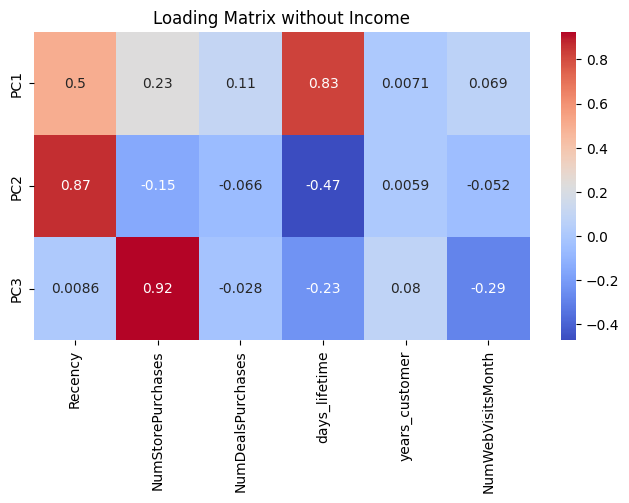

In [30]:
plt.figure(figsize=(8, 4))
sns.heatmap(loadings_w, annot=True, cmap="coolwarm")
plt.title('Loading Matrix without Income')
plt.show()

**Спостереження**:

Сумарно 3 компоненти дають ~86% — навіть трішки більше, ніж було з Income (84%).

Після видалення ознаки `"Incomes"`, бачимо, що

- PC1 найбільше залежить від days_lifetime, Recency та NumStorePurchases, як і до видалення.
- PC2 найбільше залежить від Recency та days_lifetime, як і до видалення.
- PC3 найбільше залежить від NumStorePurchases, NumWebVisitsMonth.

Можемо припускати, що `Income` не був критично важливим компонентом для структури даних у PCA-просторі. Його видалення майже не змінило залежності компонент від інших ознак, лише посилило їх роль. Простір головних компонент після вилучення Income залишився логічно зрозумілим та добре інтерпретованим, що підтверджує стійкість поведінкових патернів клієнтів у даних.

**Загальні спостереження**:

Вилучення ознаки Income не призвело до суттєвої перебудови простору головних компонент. Основна структура першої та другої головної компоненти збереглася. Проте спостерігаються зміни у третій компоненті, де раніше Income мав вагомий внесок. Після його видалення — головну роль у PC3 відіграє інша ознака.

### Завдання 5: Візуалізація кластеризації за допомогою t-SNE

Ваше завдання — використати метод t-SNE для візуалізації результатів кластеризації клієнтів у двовимірному просторі. Метод t-SNE допомагає знизити розмірність даних та зберегти локальні структури в даних, що робить його ефективним для візуалізації високорозмірних даних. Ми також зможемо порівняти результат цього методу з РСА.

1. Використайте метод t-SNE для зниження розмірності до 2х вимірів даних, які включають ознаки всі, що і в завданні 1, а також були відмасштабовані перед пониженням розмірностей.

2. Створіть новий DataFrame з координатами, отриманими після застосування t-SNE, та додайте до нього мітки кластерів.

3. Побудуйте інтерактивний 2D-графік розподілу клієнтів, де кольором буде позначено різні кластери і проаналізуйте графік з рекомендаціями нижче (можливо треба буде вивести додаткові візуалізації чи таблиці для інтерпретації, але треба прям зрозуміти, які ознаки формують який кластер і чим кластери відрізняються одне від одного).

  **Опишіть отримані кластери з точки зору ознак.**

4. Опишіть відмінність графіка tSNE від PCA.

#### ЯК можна інтерпретувати з t-SNE?

Хоча t-SNE не надає "компонентів" як РСА, він забезпечує низьковимірне представлення даних, яке можна візуально інтерпретувати:

- **Кластери:** t-SNE особливо добре показує кластери подібних точок. Якщо ви бачите чітко визначені кластери на графіку t-SNE, це свідчить про наявність груп схожих спостережень у ваших даних. Проаналізувати їх можемо, якщо додамо дані в `hover_data` або якщо якісь з даних виведемо як розмір чи форма точок на візуалізації. Також корисно може бути вивести середні значення ознак по кластерам.
- **Локальна структура:** Відносне розташування точок одного кластеру на графіку t-SNE може допомогти вам зрозуміти, які дані подібні між собою.
- **Глобальна структура:** Будьте обережні; t-SNE менш надійний для відображення глобальних структур (наприклад, відстаней між кластерами) у порівнянні з PCA, бо t-SNE націлений на збереження саме локальних структур.

In [31]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

In [32]:
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["cluster"] = clusters.astype(str)

In [33]:
print(tsne_df.head())

       TSNE1      TSNE2 cluster
0   8.364758 -36.535126       0
1 -51.520542   6.985882       2
2  -7.971858 -16.137260       2
3 -54.399918  -5.560748       2
4  -7.655323  36.549286       1


In [34]:
fig = px.scatter(
    tsne_df,
    x="TSNE1",
    y="TSNE2",
    color="cluster",
    title="t-SNE візуалізація кластерів клієнтів",
    labels={"cluster": "Кластер"},
    opacity=0.8
)
fig.show()

In [35]:
X_with_clusters = X_scaled.copy()
X_with_clusters["cluster"] = clusters

cluster_summary = X_with_clusters.groupby("cluster").mean().T
display(cluster_summary)


cluster,0,1,2
Income,0.325350,0.310045,0.315335
Recency,0.368517,0.799791,0.272312
NumStorePurchases,0.517453,0.412477,0.411020
NumDealsPurchases,0.200840,0.140000,0.125863
days_lifetime,0.791643,0.469575,0.258491
years_customer,0.262993,0.266422,0.262384
NumWebVisitsMonth,0.293838,0.261951,0.241915


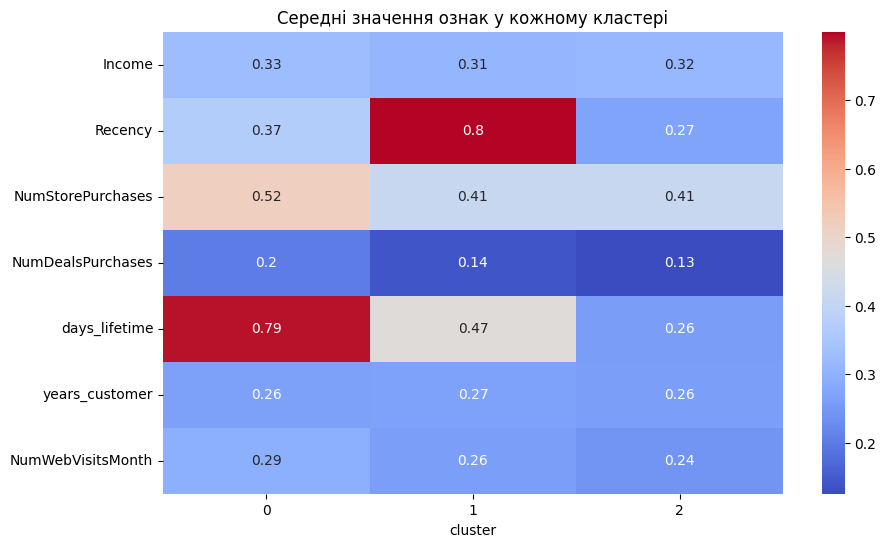

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap="coolwarm")
plt.title('Середні значення ознак у кожному кластері')
plt.show()

**Спостереження**:

- Бачимо, що візуалізації чітко виділяються три основні групи клієнтів.

- Проведено аналіз середніх значень ознак у кожному кластері, щоб краще зрозуміти їх характеристики та описати кластери з точки зору їх ознак.
Отже, маємо:
  - 0 - найбільше значенн має days_lifetime, NumStorePurchases. Значеня для  Recency -  не дуже високе. Значення даних ознак може сказати нам, що клієнти віднесені до даного кластеру, ймовірнірно постійні покупці, що часто відвідують магазин і часто користуються сайтом, і користуються в чередному частіше знижками.

  - 1 - має найвище Recency (0.80), тобто це клієнти, які давно не здійснювали покупок. days_lifetime - має не високе значення, тобто досвід клвєнтів з магазином в цілому середній. Достатньо низька активність по всіх показниках покупок. Даний кластер більше описує групу клієнтів, що деякий час з компанією, але їх активність знизилась за останній період.

  - 2 - клієнти, що віднесені до days_lifetime мають найменше. Достатньо низька авктивність покупок. Значення Recency - найнижче, отже останні покупки відбулись не так давно. Даних кластер імовірно описує клієнтів, що тільки розпочинають взаємодію з компанією.


**Відмінність графіка tSNE від PCA**

Порівнючи графіки можемо відмітити, що:

- У випадку з PCA ми можемо бачити загальну картину. Всі 3 кластери дійсно простежуються, межі між ними часто розмиті. Точки різних кластерів часто знаходяться поруч або навіть частково накладаються одна на одну. Дані мають чітку геометричну структуру, візуально це нагадує площини або прямокутні області розташування даних.

- У випадку з t-SNE бачимо, що кластери розташовані більш скупчено, і відділено. Межі між кластерами стали чіткими та очевидними — точки майже не перетинаються. Між кластерами утворились помітні "розриви", навіть більші ніж у PCA. Всередині кожного кластеру точки розташовані щільно — це показує високу схожість клієнтів у рамках кластеру.


Саме з візуалізації можемо побачити, що PCA намагається зберегти глобальну структуру, і шукає глобальні напрямки розкиду, а не конкретно подібні групи даних, і намагається максимально зберегти форму даних, не відділяючи окремі скупчення. Тоді як t-SNE на відміну від PCA орієнтується не на глобальну картину, а на локальну: для нього важливо, щоб точки, які були схожими у багатовимірному просторі, залишились близько одна до одної на графіку. Отже з t-SNE маємо спотворення відстаней між групами задля збереження подібності точок в середині кластеру.